In [1]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 10)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지
    df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상(거래량 적을 시 매수 실패할거라고 가정)

    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0) | (df2["val_last"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "시가총액": df1["cap"],
        "거래량": df1["vol"],
        "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "val": df1["val"],
        "val_last": df1["val_last"],
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1.to_csv(".analysis/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

if os.path.exists(".analysis/layer1.csv"):
    layer1 = pd.read_csv(".analysis/layer1.csv")
    layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
    layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1

,code,매수년월,매도년월,종목명,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,EBT/A_QoQ,EBT/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,53330,2014-04,2014-05,영진코퍼레이션,2014-04-30,880.0,1.862769e+10,15777003.0,1.680384e+10,0.045131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3640,2014-04,2014-05,유니온스틸,2014-04-30,14100.0,1.446660e+11,129768.0,1.908398e+09,-0.056856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68870,2014-04,2014-05,LG생명과학,2014-04-30,35750.0,5.926274e+11,2745885.0,1.013983e+11,-0.064136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86830,2014-04,2014-05,신양오라컴디스플레이,2014-04-30,3295.0,2.313090e+10,1654819.0,5.322223e+09,0.069805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200916,42670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,0.029118,-0.050384,0.017786,0.020540,0.015882,0.033000,0.015612,0.033128,0.011726,0.025061
200917,54620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,0.004770,0.005569,-0.002981,-0.006491,-0.005834,-0.008222,-0.007104,-0.015276,-0.006268,-0.012965
200918,238500,2023-09,2023-10,로보쓰리에이아이앤로보틱스,2023-09-27,936.0,2.013819e+10,5678047.0,4.715497e+09,0.485714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200919,424980,2023-09,2023-10,마이크로투나노,2023-09-27,16300.0,9.647791e+10,1606473.0,3.070538e+10,-0.128342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
    }
)

factors = [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
factors += ["P"]

# 가격비율
layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
factors.append("EQ/P")

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    factor = f"{col}/P"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["P"]
    factors.append(factor)

# 자산비율
for col in is_cols:
    factor = f"{col}/A"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["A"]
    factors.append(factor)

# 자본비율
for col in is_cols:
    factor = f"{col}/EQ"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["EQ"]
    factors.append(factor)

# 이익율
for col in is_cols:
    factor = f"{col}/R"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["R/Y"]
    factors.append(factor)

layer2["순운전자본회전율"] = layer2["R/Y"] / layer2["순운전자본"]

factors += [
    "순운전자본회전율",
    "재고자산순운전자본비율",
]

recipes = {
    "순운전자본회전율": {"순운전자본회전율": 1},
    "재고자산순운전자본비율": {"재고자산순운전자본비율": 1},
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "퀄리티": {
        "GP/EQ": 0.081688,
        "GP/A": 0.068516,
        "O/A": 0.059149,
        "O/R": 0.056152,
        "O/EQ": 0.054418,
        "R/EQ": 0.053285,
        "EBT/A": 0.042171,
        "EBT/R": 0.035214,
        "GP/R": 0.034800,
        "EBT/EQ": 0.034718
    },
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
        "퀄리티": 1
    },
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    for title, recipe in recipes.items():
        # df[title] = pd.concat(
        #     [(df[f"{k}_pct"] if w > 0 else 1 / df[f"{k}"]) ** abs(w) for k, w in recipe.items()],
        #     axis=1
        # ).prod(axis=1, skipna=False)
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    result = pd.concat([result, df])

result

2023-10

,code,매수년월,매도년월,종목명,매수일,매수가,P,거래량,TV,전월수익률,...,순운전자본회전율_pct,재고자산순운전자본비율_pct,벨류,벨류_pct,퀄리티,퀄리티_pct,성장,성장_pct,전략,전략_pct
0,53330,2014-04,2014-05,영진코퍼레이션,2014-04-30,880.0,1.862769e+10,15777003.0,1.680384e+10,0.045131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3640,2014-04,2014-05,유니온스틸,2014-04-30,14100.0,1.446660e+11,129768.0,1.908398e+09,-0.056856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68870,2014-04,2014-05,LG생명과학,2014-04-30,35750.0,5.926274e+11,2745885.0,1.013983e+11,-0.064136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86830,2014-04,2014-05,신양오라컴디스플레이,2014-04-30,3295.0,2.313090e+10,1654819.0,5.322223e+09,0.069805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200916,42670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,55.0,88.0,129.0,67.0,42.866417,95.0,89.815645,90.0,159.0,82.0
200917,54620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,7.0,11.0,97.0,49.0,12.174374,14.0,46.988587,42.0,57.0,26.0
200918,238500,2023-09,2023-10,로보쓰리에이아이앤로보틱스,2023-09-27,936.0,2.013819e+10,5678047.0,4.715497e+09,0.485714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200919,424980,2023-09,2023-10,마이크로투나노,2023-09-27,16300.0,9.647791e+10,1606473.0,3.070538e+10,-0.128342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[6/6] 전략티산순운전자본비율2014-04 2023-10
             순운전자본회전율  재고자산순운전자본비율   벨류       퀄리티        성장   전략
순운전자본회전율          1.0          NaN  NaN       NaN       NaN  NaN
재고자산순운전자본비율       NaN          1.0  NaN       NaN       NaN  NaN
GP/P              NaN          NaN  1.0       NaN       NaN  NaN
EQ/P              NaN          NaN  1.0       NaN       NaN  NaN
GP/EQ             NaN          NaN  NaN  0.081688       NaN  NaN
GP/A              NaN          NaN  NaN  0.068516       NaN  NaN
O/A               NaN          NaN  NaN  0.059149       NaN  NaN
O/R               NaN          NaN  NaN  0.056152       NaN  NaN
O/EQ              NaN          NaN  NaN  0.054418       NaN  NaN
R/EQ              NaN          NaN  NaN  0.053285       NaN  NaN
EBT/A             NaN          NaN  NaN  0.042171       NaN  NaN
EBT/R             NaN          NaN  NaN  0.035214       NaN  NaN
GP/R              NaN          NaN  NaN  0.034800       NaN  NaN
EBT/EQ            NaN          NaN  NaN  0.034718       N

,spearman,kendall,h5,h10,t5,t10,mdd5,h10-t10,mean,median,strength
전략,0.861854,0.683636,0.245694,0.239892,-0.144508,-0.119940,-0.311295,0.359832,0.047424,0.045006,0.310123
벨류,0.717552,0.530101,0.103902,0.120987,-0.102079,-0.082320,-0.462221,0.203306,0.043531,0.046374,0.145883
성장,0.750099,0.563232,0.135912,0.139918,-0.035336,-0.014007,-0.422307,0.153924,0.047181,0.054412,0.115458
퀄리티,0.242832,0.156364,0.034938,0.039320,-0.044429,-0.031421,-0.425786,0.070741,0.046148,0.046344,0.017178
재고자산순운전자본비율,0.325257,0.216970,0.067509,0.048734,-0.013464,0.010038,-0.448639,0.038696,0.044157,0.046910,0.012586
순운전자본회전율,0.130201,0.087677,0.031718,0.042164,-0.037036,-0.007200,-0.429187,0.049364,0.045297,0.045430,0.006427


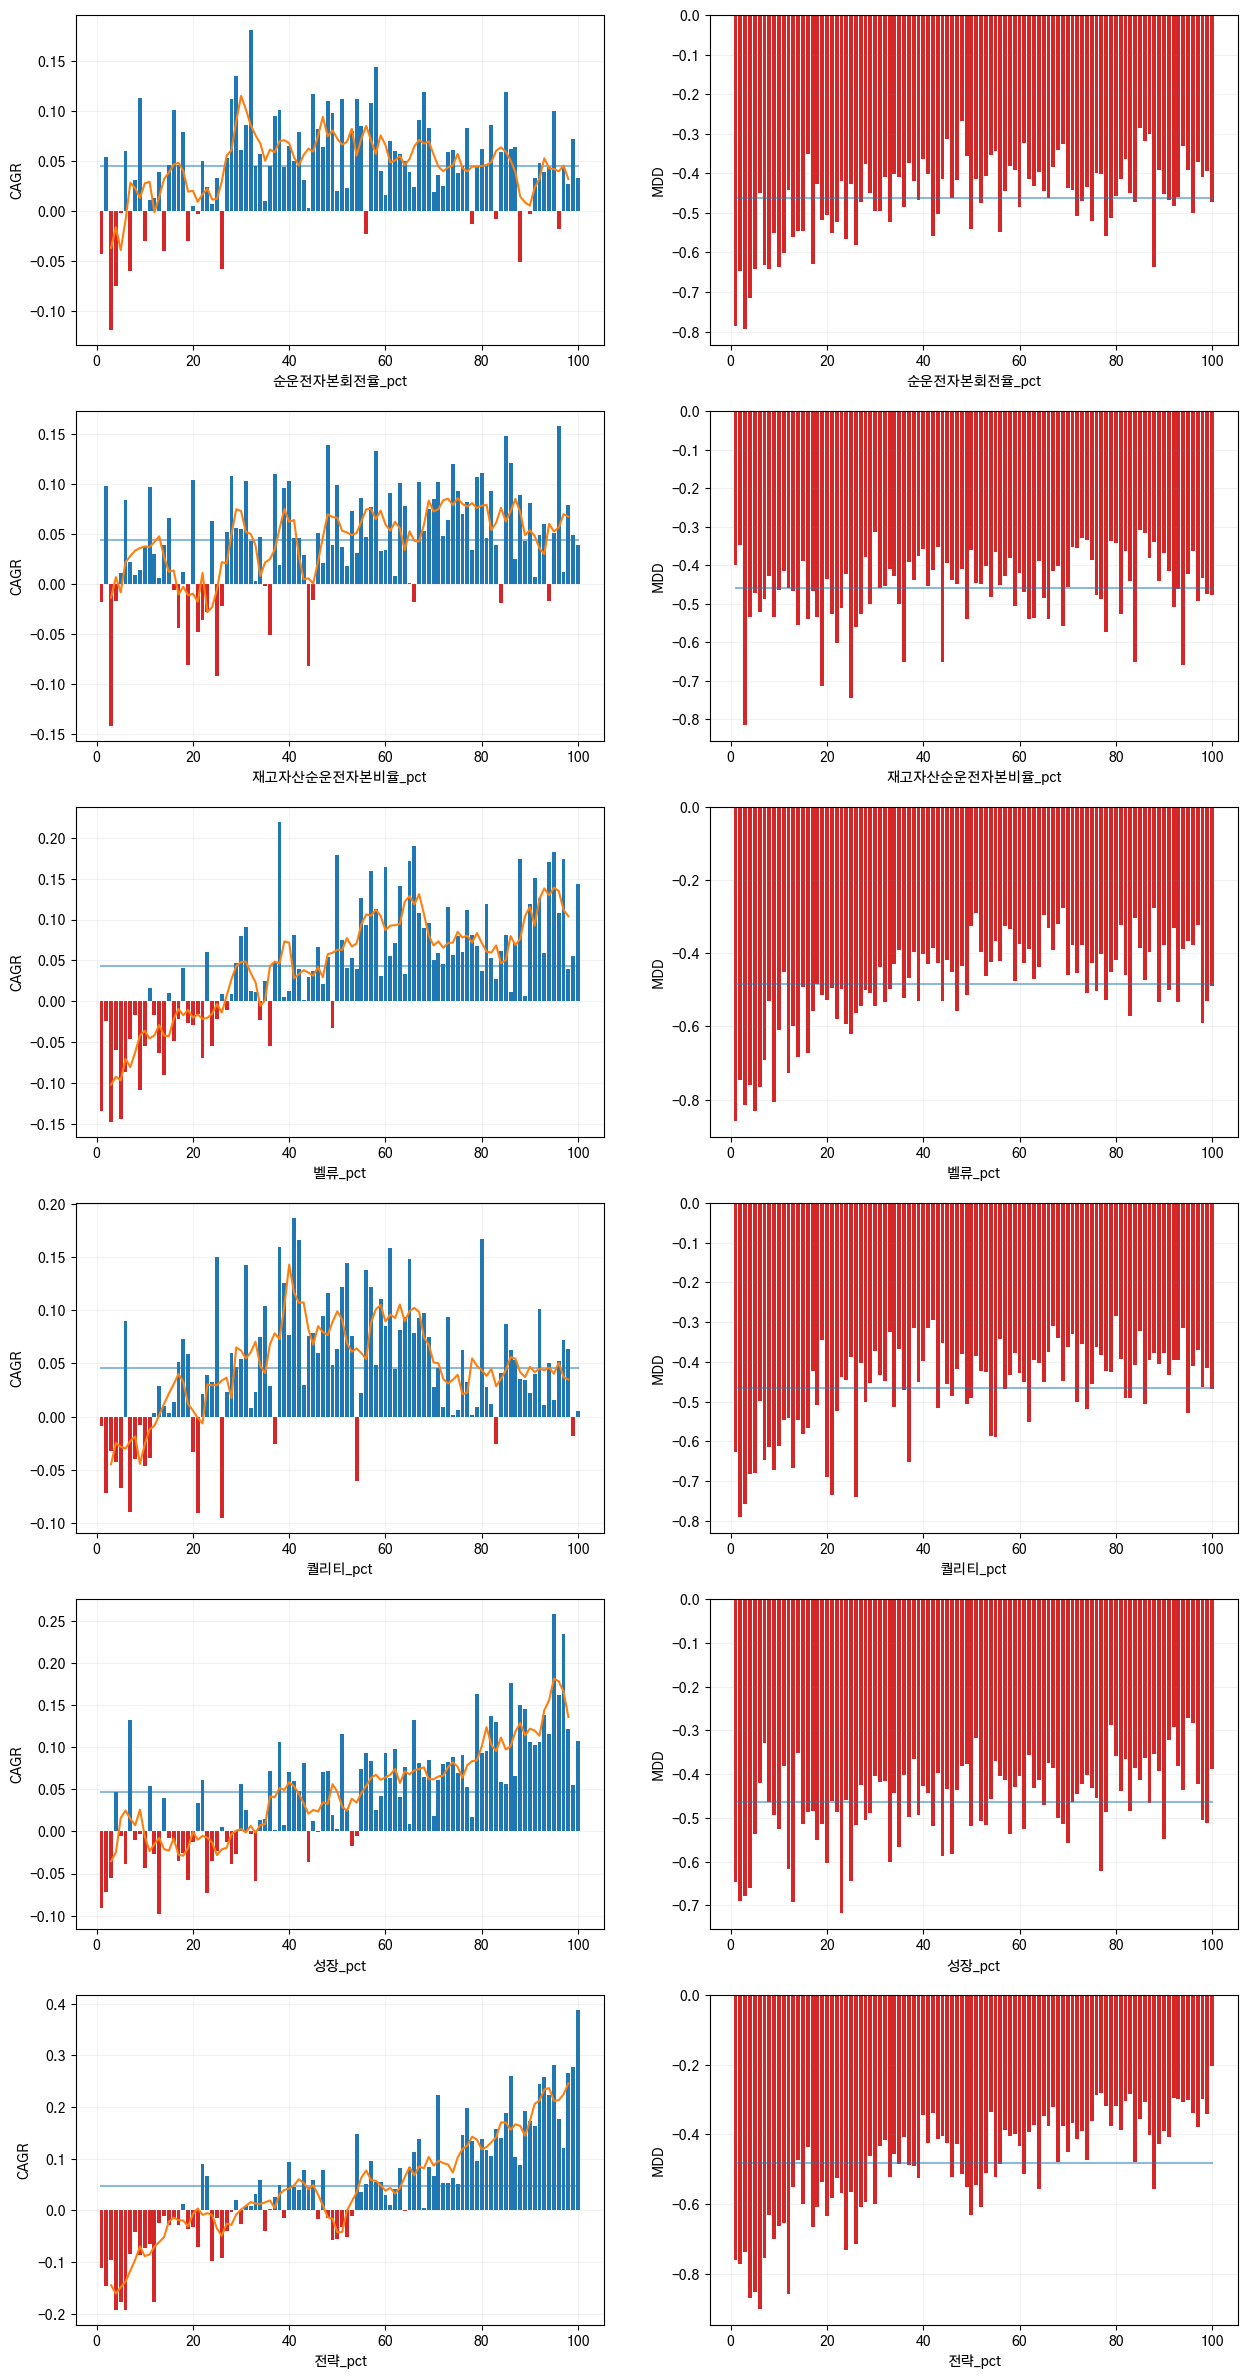

In [10]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(15), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))
summary = summary.sort_values(by="strength", ascending=False)
summary

In [11]:
# 백테스트: 매매 시뮬레이션

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

head = 20
strategy = result2.dropna().groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})

years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["벤치마크 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].dropna().index], revisions["전략 누적수익률"].dropna().tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "val_last", "P_pct", "성장_pct", "벨류_pct", "퀄리티_pct",
     f"{factor}_pct"]]
result3.to_csv(".analysis/result3.csv")
result3

전략
          CAGR                                         MDD      Mean
전략    0.387670  (-0.22951095374673003, (2018-05, 2018-10))  0.030775
벤치마크  0.029775  (-0.39749020543683156, (2018-05, 2020-03))  0.004336


code     종목명       수익률         매수일         매도일  \
매수년월    매도년월                                                               
2014-04 2014-05 169       8350   남선알미늄  0.434893  2014-04-30  2014-05-30   
                931     120030    조선선재  0.272158  2014-04-30  2014-05-30   
                744      51630    진양화학  0.218310  2014-04-30  2014-05-30   
                662      33100    제룡전기  0.131462  2014-04-30  2014-05-30   
                682      24940    PN풍년  0.103774  2014-04-30  2014-05-30   
...                        ...     ...       ...         ...         ...   
2023-09 2023-10 199483   53270    구영테크 -0.080756  2023-09-27  2023-10-27   
                199291   42940   상지카일룸 -0.083499  2023-09-27  2023-10-27   
                199867   31820   콤텍시스템 -0.089136  2023-09-27  2023-10-27   
                199323   38010  제일테크노스 -0.101887  2023-09-27  2023-10-27   
                200411  900340    윙입푸드 -0.135556  2023-09-27  2023-10-27   

                            매수가      매도가     val_last  P_pct  성장_pct  벨류_pct  \
매수년월    매도년월                                                                   
2014-04 2014-05 169       791.0   1135.0  249391143.0   37.0    99.0    70.0   
                931     47950.0  61000.0  410435350.0   24.0    98.0    53.0   
                744      2840.0   3460.0  109249025.0    9.0    93.0    59.0   
                662      3385.0   3830.0  109765100.0   13.0    99.0    51.0   
                682      2120.0   2340.0  125729995.0    3.0    93.0    92.0   
...                         ...      ...          ...    ...     ...     ...   
2023-09 2023-10 199483   2910.0   2675.0  368551965.0   21.0    99.0    76.0   
                199291    503.0    461.0  172462681.0   10.0   100.0    86.0   
                199867    718.0    654.0  212138760.0   26.0    85.0    94.0   
                199323   7950.0   7140.0  273102960.0   18.0    95.0    79.0   
                200411    900.0    778.0  401529679.0    6.0    74.0    97.0   

                        퀄리티_pct  전략_pct  
매수년월    매도년월                             
2014-04 2014-05 169        73.0    98.0  
                931        92.0    99.0  
                744        87.0   100.0  
                662        69.0    99.0  
                682        55.0   100.0  
...                         ...     ...  
2023-09 2023-10 199483     85.0   100.0  
                199291     91.0   100.0  
                199867     81.0    99.0  
                199323     94.0   100.0  
                200411     83.0   100.0  

[2280 rows x 13 columns]

In [12]:
revisions.to_csv(".analysis/revisions.csv")
revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2014-04,2014-05,-0.010339,0.032425,0.04,0.989661,1.032425
2014-05,2014-06,-0.013571,0.048292,0.06,0.976230,1.082283
2014-06,2014-07,0.014194,-0.015194,-0.03,0.990087,1.065839
2014-07,2014-08,0.039853,0.052065,0.01,1.029545,1.121332
2014-08,2014-09,0.005352,0.090495,0.09,1.035055,1.222806
...,...,...,...,...,...,...
2023-05,2023-06,0.006412,0.088814,0.08,1.563446,25.648718
2023-06,2023-07,-0.029541,-0.061763,-0.03,1.517259,24.064572
2023-07,2023-08,0.016191,0.003070,-0.01,1.541825,24.138448


total          114.000000
out-perform     79.000000
승률               0.692982
누적 성능           16.670364
dtype: float64

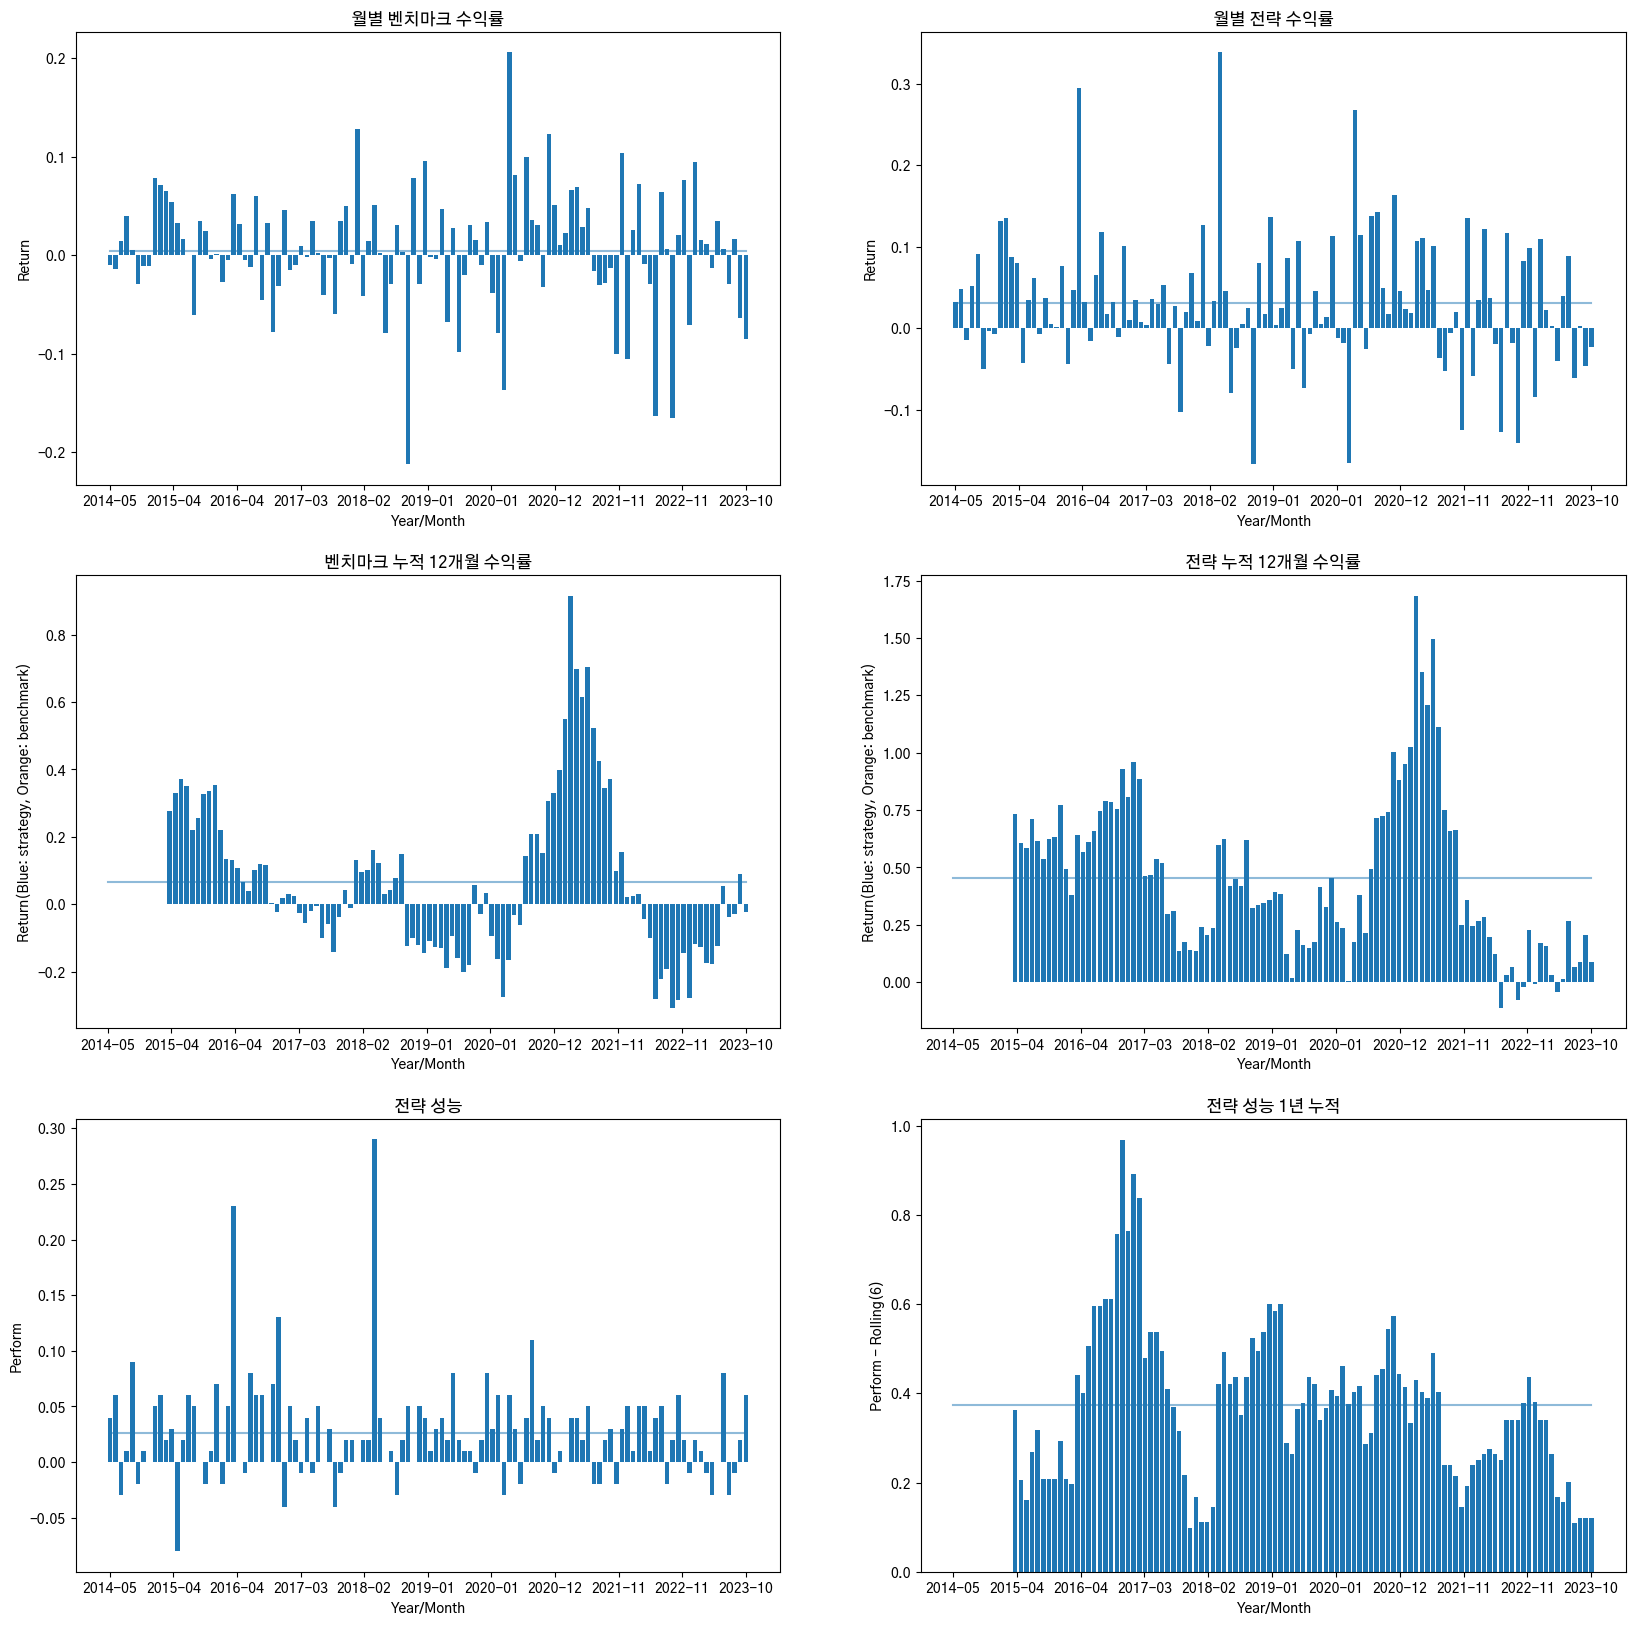

In [13]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": len(revisions[revisions["성능"] > 0]),
    "승률": len(revisions[revisions["성능"] > 0]) / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})